<a href="https://colab.research.google.com/github/Michal287/computer_vision/blob/main/Cellpose_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies


In [ ]:
!pip uninstall -y -q yellowbrick
!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install "opencv-python-headless<4.3"
!pip install -q cellpose
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf2

# Folder architecture

In [ ]:
%mkdir data_tiff
%cd data_tiff
%mkdir -p fiji/images fiji/masks numpy/images numpy/masks raw/images raw/masks
%cd ..
%ls -l

/content/data_tiff
/content
total 8
drwxr-xr-x 5 root root 4096 Sep  1 13:25 data_tiff/
drwxr-xr-x 1 root root 4096 Aug 30 13:25 sample_data/


# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!7z x /content/drive/MyDrive/data.zip

Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 6910524886 bytes (6591 MiB)

Extracting archive: /content/drive/MyDrive/data.zip
  4% 256 Open               9% 512 Open              13% 768 Open              18% 1024 Open               23% 1280 Open               27% 1536 Open               32% 1792 Open               36% 2048 Open               41% 2304 Open               46% 2560 Open  

# Create masks from COCO

In [ ]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_mask_from_coco(coco_file, mask_dir):

    def create_mask(annotations, img_shape):
        mask = np.zeros(img_shape, dtype=np.uint8)
        for idx, ann in enumerate(annotations):
            segment = np.array(ann['segmentation'][0]).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [segment], idx+1)
        return mask

    # Załaduj dane COCO
    with open(coco_file, 'r') as f:
        data = json.load(f)

    # Stwórz folder dla maski, jeśli nie istnieje
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)

    # Przetwórz każde zdjęcie w zestawie danych COCO
    for image_info in data['images']:
        img_id = image_info['id']
        img_width = image_info['width']
        img_height = image_info['height']

        # Znajdź wszystkie adnotacje dla danego obrazu
        relevant_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]

        mask = create_mask(relevant_annotations, (img_height, img_width))

        mask_filename = os.path.join(mask_dir, image_info['file_name'])
        cv2.imwrite(mask_filename, mask)

create_mask_from_coco(coco_file = '/content/data/part1/train/labels.json',
                      mask_dir = '/content/data/part1/train/masks')


# Convert data to tiff (8 bit image)

In [ ]:
from PIL import Image

images = os.listdir('/content/data/part1/train/masks')

for image_path in images:
    # Wczytaj obraz
    img = Image.open(f'/content/data/part1/train/images/{image_path}')
    mask = Image.open(f'/content/data/part1/train/masks/{image_path}')

    rename = image_path.split(".")

    img = img.convert("RGB")

    img.save(f'/content/data_tiff/numpy/images/{rename[0]}.tif')
    mask.save(f'/content/data_tiff/numpy/masks/{rename[0]}.tif')

## **3.1. Setting main training parameters**
---
<font size = 4>

In [ ]:
#@markdown ###Path to training images:

Training_source = "/content/data_tiff/numpy/images" #@param {type:"string"}
Training_target = "/content/data_tiff/numpy/masks" #@param {type:"string"}

#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "Cellpose" #@param {type:"string"}
model_path = "" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
number_of_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = False #@param {type:"boolean"}
#@markdown ###If not, please input:
batch_size =  8#@param {type:"number"}
initial_learning_rate = 0.0002 #@param {type:"number"}
percentage_validation =  10#@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  batch_size = 8
  initial_learning_rate = 0.0002
  percentage_validation = 10

#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  print(bcolors.WARNING +"To continue training "+model_name+", choose a new model_name here, and load "+model_name+" in section 3.3"+W)

# Here we enable the cyto pre-trained model by default (in case the  cell is not ran)
model_to_load = "cyto"
# Here we disable data augmentation by default (in case the cell is not ran)

Use_Data_augmentation = True

# This will display a randomly chosen dataset input and output
random_choice = random.choice(os.listdir(Training_source))
x = io.imread(Training_source+"/"+random_choice)
norm = simple_norm(x, percent = 99)
y = io.imread(Training_target+"/"+random_choice)

# Find the number of channel in the input image

n_channel = 1 if x.ndim == 2 else x.shape[-1]


# Here we match the channel to number

if Channel_to_use_for_training == "Grayscale":
  Training_channel = 0

  if not n_channel == 1:
      print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for trainning !!")

if Channel_to_use_for_training == "Blue":
  Training_channel = 3

if Channel_to_use_for_training == "Green":
  Training_channel = 2

if Channel_to_use_for_training == "Red":
  Training_channel = 1


if Second_training_channel == "Blue":
  Second_training_channel = 3

if Second_training_channel == "Green":
  Second_training_channel = 2

if Second_training_channel == "Red":
  Second_training_channel = 1

if Second_training_channel == "None":
  Second_training_channel = 0


if n_channel ==1:

  f=plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.imshow(x, norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Training source')
  plt.axis('off');

  plt.subplot(1,2,2)
  plt.imshow(y,cmap='nipy_spectral', interpolation='nearest')
  plt.title('Training target')
  plt.axis('off');

  plt.savefig('/content/TrainingDataExample_Cellpose2D.png',bbox_inches='tight',pad_inches=0)

else:

  f=plt.figure(figsize=(20,10))
  plt.subplot(1,3,1)
  plt.imshow(x, interpolation='nearest')
  plt.title('Training source')
  plt.axis('off');

  plt.subplot(1,3,2)
  plt.imshow(x[:, :, int(Training_channel-1)],cmap='magma', interpolation='nearest')
  plt.title('Channel used for training')
  plt.axis('off');

  plt.subplot(1,3,3)
  plt.imshow(y,cmap='nipy_spectral', interpolation='nearest')
  plt.title('Training target')
  plt.axis('off');

  plt.savefig('/content/TrainingDataExample_Cellpose2D.png',bbox_inches='tight',pad_inches=0)

NameError: ignored

## **3.2. Data augmentation**
---
<font size = 4>

<font size = 4>Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation. Augmentation is not necessary for training and if your training dataset is large you should disable it.

<font size = 4>By default, a x4 data augmentation is enabled in this notebook.

In [ ]:
#Data augmentation

Use_Data_augmentation = True #@param {type:"boolean"}

if Use_Data_augmentation:
  print(bcolors.WARNING+"Data augmentation enabled")
  Multiply_dataset_by = 4


if not Use_Data_augmentation:
  print(bcolors.WARNING+"Data augmentation disabled")

Data augmentation enabled



## **3.3. Using weights from a pre-trained model as initial weights**
---
<font size = 4>  Here, you can set the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. **This pre-trained model needs to be a Cellpose model**.

<font size = 4>  You can also use the pretrained models already available in Cellpose:

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.

- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The nuclear model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

<font size = 4> This option allows you to perform training over multiple Colab runtimes or to do transfer learning using models trained outside of ZeroCostDL4Mic. **You do not need to run this section if you want to train a network from scratch**.


In [ ]:
# @markdown ##Loading weights from a pre-trained network

Use_pretrained_model = False #@param {type:"boolean"}

Pretrained_model = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2", "Nuclei", "LiveCell", "TissueNet", "Own_model"]

#@markdown ###If using your own model, please provide the path to the model (not the folder):
pretrained_model_path = "" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------

if Use_pretrained_model == True :

  if Pretrained_model == "Own_model":

    model_to_load = pretrained_model_path

    print('The model '+ str(model_to_load) + "will be used as a starting point")

  if Pretrained_model == "Cytoplasm":
    model_to_load = "cyto"
    print('The model Cytoplasm will be used as a starting point')

  if Pretrained_model == "Cytoplasm2":
    model_to_load = "cyto2"
    print('The model Cytoplasm2 (cyto2) will be used as a starting point')

  if Pretrained_model == "Nuclei":
    model_to_load = "nuclei"
    print('The model nuclei will be used as a starting point')

  if Pretrained_model == "LiveCell":
    model_to_load = "livecell"
    print('The model LiveCell will be used as a starting point')

  if Pretrained_model == "TissueNet":
    model_to_load = "tissuenet"
    print('The model TissueNet will be used as a starting point')

else:
  model_to_load = None
  print(bcolors.WARNING+'No pretrained network will be used.')



No pretrained network will be used.


#**4. Train the network**
---

In [ ]:
!ls -a /content/data_tiff/numpy/images/

.  ..  0a30487a4e.tif  0a55e7c93f.tif


In [ ]:
!rm -rf /content/data_tiff/numpy/images/.ipynb_checkpoints

In [ ]:
#@markdown ##Create the model and dataset objects


# Here we check that the model destination folder is empty
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Model folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)

os.makedirs(model_path+"/"+model_name)


#To use cellpose to work we need to organise the data in a way the network can understand

# Here we count the number of files in the training target folder
Filelist = os.listdir(Training_target)
number_files = len(Filelist)

# Here we count the number of file to use for validation
Image_for_validation =  int((number_files)*(percentage_validation/100))

if Image_for_validation == 0:
  Image_for_validation = 1

Saving_path= "/content/"+model_name

if os.path.exists(Saving_path):
  shutil.rmtree(Saving_path)
os.makedirs(Saving_path)

train_folder = Saving_path+"/train_folder"
os.makedirs(train_folder)

test_folder = Saving_path+"/test_folder"
os.makedirs(test_folder)

index = 0

print('Copying training source data...')
for f in tqdm(os.listdir(Training_source)):
    short_name = os.path.splitext(f)

    if index < Image_for_validation:
      shutil.copyfile(Training_source+"/"+f, test_folder+"/"+short_name[0]+"_img.tif")
      shutil.copyfile(Training_target+"/"+f, test_folder+"/"+short_name[0]+"_masks.tif")
    else:
      shutil.copyfile(Training_source+"/"+f, train_folder+"/"+short_name[0]+"_img.tif")
      shutil.copyfile(Training_target+"/"+f, train_folder+"/"+short_name[0]+"_masks.tif")
    index = index +1

print("Done")

pdf_export(augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)



Copying training source data...


100%|██████████| 767/767 [00:10<00:00, 69.96it/s]


Done


## **4.2. Start Training**
---

<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Training is currently done using Torch.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches. Another way circumvent this is to save the parameters of the model after training and start training again from this point.


In [ ]:
start = time.time()

if not Use_Data_augmentation:
  !python -m cellpose --train --use_gpu --fast_mode --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks --verbose

else:
  !python -m cellpose --train --use_gpu --fast_mode --dir "$train_folder" --test_dir "$test_folder" --pretrained_model $model_to_load --chan $Training_channel --chan2 $Second_training_channel --n_epochs $number_of_epochs --learning_rate $initial_learning_rate --batch_size $batch_size --img_filter img --mask_filter masks --verbose


#Settings
# --check_mkl', action='store_true', help='check if mkl working'

#'--mkldnn', action='store_true', help='for mxnet, force MXNET_SUBGRAPH_BACKEND = "MKLDNN"')

#'--train', action='store_true', help='train network using images in dir')
#'--dir', required=False, help='folder containing data to run or train on')
#  '--mxnet', action='store_true', help='use mxnet')
#  '--img_filter', required=False, default=[], type=str, help='end string for images to run on')
#  '--use_gpu', action='store_true', help='use gpu if mxnet with cuda installed')
#   '--fast_mode', action='store_true', help="make code run faster by turning off 4 network averaging")
#  '--resample', action='store_true', help="run dynamics on full image (slower for images with large diameters)")
# '--no_interp', action='store_true', help='do not interpolate when running dynamics (was default)')
#  '--do_3D', action='store_true',  help='process images as 3D stacks of images (nplanes x nchan x Ly x Lx')

# settings for training
#    parser.add_argument('--train_size', action='store_true', help='train size network at end of training')
#    parser.add_argument('--mask_filter', required=False, default='_masks', type=str, help='end string for masks to run on')
#    parser.add_argument('--test_dir', required=False, default=[], type=str, help='folder containing test data (optional)')
#    parser.add_argument('--learning_rate', required=False, default=0.2, type=float, help='learning rate')
#    parser.add_argument('--n_epochs', required=False, default=500, type=int, help='number of epochs')
#    parser.add_argument('--batch_size', required=False, default=8, type=int, help='batch size')
#    parser.add_argument('--residual_on', required=False, default=1, type=int, help='use residual connections')
#    parser.add_argument('--style_on', required=False, default=1, type=int, help='use style vector')
#    parser.add_argument('--concatenation', required=False, dfault=0, type=int, help='concatenate downsampled layers with upsampled layers (off by default which means they are added)')

# epoch 70 1.3loss

#Here we copy the model to the result folder after training

if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: Model folder already exists and has been removed !!" + W)
  shutil.rmtree(model_path+'/'+model_name)
destination = shutil.copytree(Saving_path+"/train_folder/models", model_path+"/"+model_name)

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")
print("Your model is also available here: "+str(model_path+"/"+model_name))


pdf_export(trained=True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)



creating new log file
2023-09-01 12:22:02,491 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2023-09-01 12:22:02,491 [INFO] 
cellpose version: 	2.2.3 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.0.1+cu118
2023-09-01 12:22:02,755 [INFO] ** TORCH CUDA version installed and working. **
2023-09-01 12:22:02,755 [INFO] >>>> using GPU
2023-09-01 12:22:02,791 [INFO] not all flows are present, running flow generation for all images
2023-09-01 12:22:05,520 [INFO] 691 / 691 images in /content/CellPoseModel/train_folder folder have labels
2023-09-01 12:22:05,525 [INFO] not all flows are present, running flow generation for all images
2023-09-01 12:22:05,825 [INFO] 76 / 76 images in /content/CellPoseModel/test_folder folder have labels
2023-09-01 12:22:05,825 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
2023-09-01 12:23:23,188 [INFO] computing flows for labels
100% 691/691 [08:33<00:00,  1.35it/s]
2023-09-01 12:33:29,603 [INFO] computi

# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model.  


<font size = 4>**We highly recommend to perform quality control on all newly trained models.**

<font size = 4>**`model_choice`:** Choose the model to use to make predictions. This model needs to be a Cellpose model. You can also use the pretrained models already available in cellpose:

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.
- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The Nuclei model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

- The 'livecell' model was trained on all training images from the [livecell dataset](https://sartorius-research.github.io/LIVECell/). These images only have a cytoplasm channel.

- The 'tissuenet' model was trained on all training images from the [tissuenet dataset](https://datasets.deepcell.org/). These images have a cytoplasm channel and a nuclear channel

- The bacteria Omnipose model is an Omnipose model dedicated to the segmentation of bacteria or other elongated cells.

- The cytoplasm2 Omnipose model is an Omnipose model trained using the same dataset as the cellpose cytoplasm2 model.




In [ ]:

QC_model = "Own_model"
QC_model_path = "/content/CellPoseModel/train_folder/models/cellpose_residual_on_style_on_concatenation_off_train_folder_2023_08_31_23_07_5.021137"

Saving_path = ""

list_files = os.listdir(model_path+"/"+model_name)

QC_model = "Own_model"

model = models.CellposeModel(gpu=True, pretrained_model=QC_model_path, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

QC_model_folder = os.path.dirname(QC_model_path)
Saving_path = QC_model_folder
QC_model_name = os.path.basename(QC_model_folder)
print("The "+str(QC_model_name)+" model will be evaluated")
#Here we make the folder to save the resuslts if it does not exists

if not Saving_path == "":
  if os.path.exists(QC_model_folder) == False:
    os.makedirs(QC_model_folder)
else:
  print(bcolors.WARNING+'!! WARNING: Indicate where you want to save the results')


# Here we load the def that perform the QC, code taken from StarDist  https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py

import numpy as np
from numba import jit
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import namedtuple


matching_criteria = dict()

def label_are_sequential(y):
    """ returns true if y has only sequential labels from 1... """
    labels = np.unique(y)
    return (set(labels)-{0}) == set(range(1,1+labels.max()))


def is_array_of_integers(y):
    return isinstance(y,np.ndarray) and np.issubdtype(y.dtype, np.integer)


def _check_label_array(y, name=None, check_sequential=False):
    err = ValueError("{label} must be an array of {integers}.".format(
        label = 'labels' if name is None else name,
        integers = ('sequential ' if check_sequential else '') + 'non-negative integers',
    ))
    is_array_of_integers(y) or print("An error occured")
    if check_sequential:
        label_are_sequential(y) or print("An error occured")
    else:
        y.min() >= 0 or print("An error occured")
    return True


def label_overlap(x, y, check=True):
    if check:
        _check_label_array(x,'x',True)
        _check_label_array(y,'y',True)
        x.shape == y.shape or _raise(ValueError("x and y must have the same shape"))
    return _label_overlap(x, y)

@jit(nopython=True)
def _label_overlap(x, y):
    x = x.ravel()
    y = y.ravel()
    overlap = np.zeros((1+x.max(),1+y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1
    return overlap


def intersection_over_union(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / (n_pixels_pred + n_pixels_true - overlap)

matching_criteria['iou'] = intersection_over_union


def intersection_over_true(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / n_pixels_true

matching_criteria['iot'] = intersection_over_true


def intersection_over_pred(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    return overlap / n_pixels_pred

matching_criteria['iop'] = intersection_over_pred


def precision(tp,fp,fn):
    return tp/(tp+fp) if tp > 0 else 0
def recall(tp,fp,fn):
    return tp/(tp+fn) if tp > 0 else 0
def accuracy(tp,fp,fn):
    # also known as "average precision" (?)
    # -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
    return tp/(tp+fp+fn) if tp > 0 else 0
def f1(tp,fp,fn):
    # also known as "dice coefficient"
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


def _safe_divide(x,y):
    return x/y if y>0 else 0.0

def matching(y_true, y_pred, thresh=0.5, criterion='iou', report_matches=False):
    """Calculate detection/instance segmentation metrics between ground truth and predicted label images.
    Currently, the following metrics are implemented:
    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'
    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)
    * mean_matched_score is the mean IoUs of matched true positives
    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects
    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019
    Parameters
    ----------
    y_true: ndarray
        ground truth label image (integer valued)
        predicted label image (integer valued)
    thresh: float
        threshold for matching criterion (default 0.5)
    criterion: string
        matching criterion (default IoU)
    report_matches: bool
        if True, additionally calculate matched_pairs and matched_scores (note, that this returns even gt-pred pairs whose scores are below  'thresh')
    Returns
    -------
    Matching object with different metrics as attributes
    Examples
    --------
    >>> y_true = np.zeros((100,100), np.uint16)
    >>> y_true[10:20,10:20] = 1
    >>> y_pred = np.roll(y_true,5,axis = 0)
    >>> stats = matching(y_true, y_pred)
    >>> print(stats)
    Matching(criterion='iou', thresh=0.5, fp=1, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=1, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0)
    """
    _check_label_array(y_true,'y_true')
    _check_label_array(y_pred,'y_pred')
    y_true.shape == y_pred.shape or _raise(ValueError("y_true ({y_true.shape}) and y_pred ({y_pred.shape}) have different shapes".format(y_true=y_true, y_pred=y_pred)))
    criterion in matching_criteria or _raise(ValueError("Matching criterion '%s' not supported." % criterion))
    if thresh is None: thresh = 0
    thresh = float(thresh) if np.isscalar(thresh) else map(float,thresh)

    y_true, _, map_rev_true = relabel_sequential(y_true)
    y_pred, _, map_rev_pred = relabel_sequential(y_pred)

    overlap = label_overlap(y_true, y_pred, check=False)
    scores = matching_criteria[criterion](overlap)
    assert 0 <= np.min(scores) <= np.max(scores) <= 1

    # ignoring background
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    def _single(thr):
        not_trivial = n_matched > 0 and np.any(scores >= thr)
        if not_trivial:
            # compute optimal matching with scores as tie-breaker
            costs = -(scores >= thr).astype(float) - scores / (2*n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            assert n_matched == len(true_ind) == len(pred_ind)
            match_ok = scores[true_ind,pred_ind] >= thr
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        fp = n_pred - tp
        fn = n_true - tp
        # assert tp+fp == n_pred
        # assert tp+fn == n_true

        # the score sum over all matched objects (tp)
        sum_matched_score = np.sum(scores[true_ind,pred_ind][match_ok]) if not_trivial else 0.0

        # the score average over all matched objects (tp)
        mean_matched_score = _safe_divide(sum_matched_score, tp)
        # the score average over all gt/true objects
        mean_true_score    = _safe_divide(sum_matched_score, n_true)
        panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

        stats_dict = dict (
            criterion          = criterion,
            thresh             = thr,
            fp                 = fp,
            tp                 = tp,
            fn                 = fn,
            precision          = precision(tp,fp,fn),
            recall             = recall(tp,fp,fn),
            accuracy           = accuracy(tp,fp,fn),
            f1                 = f1(tp,fp,fn),
            n_true             = n_true,
            n_pred             = n_pred,
            mean_true_score    = mean_true_score,
            mean_matched_score = mean_matched_score,
            panoptic_quality   = panoptic_quality,
        )
        if bool(report_matches):
            if not_trivial:
                stats_dict.update (
                    # int() to be json serializable
                    matched_pairs  = tuple((int(map_rev_true[i]),int(map_rev_pred[j])) for i,j in zip(1+true_ind,1+pred_ind)),
                    matched_scores = tuple(scores[true_ind,pred_ind]),
                    matched_tps    = tuple(map(int,np.flatnonzero(match_ok))),
                )
            else:
                stats_dict.update (
                    matched_pairs  = (),
                    matched_scores = (),
                    matched_tps    = (),
                )
        return namedtuple('Matching',stats_dict.keys())(*stats_dict.values())

    return _single(thresh) if np.isscalar(thresh) else tuple(map(_single,thresh))



def matching_dataset(y_true, y_pred, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):
    """matching metrics for list of images, see `stardist.matching.matching`
    """
    len(y_true) == len(y_pred) or _raise(ValueError("y_true and y_pred must have the same length."))
    return matching_dataset_lazy (
        tuple(zip(y_true,y_pred)), thresh=thresh, criterion=criterion, by_image=by_image, show_progress=show_progress, parallel=parallel,
    )



def matching_dataset_lazy(y_gen, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):

    expected_keys = set(('fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'))

    single_thresh = False
    if np.isscalar(thresh):
        single_thresh = True
        thresh = (thresh,)

    tqdm_kwargs = {}
    tqdm_kwargs['disable'] = not bool(show_progress)
    if int(show_progress) > 1:
        tqdm_kwargs['total'] = int(show_progress)

    # compute matching stats for every pair of label images
    if parallel:
        from concurrent.futures import ThreadPoolExecutor
        fn = lambda pair: matching(*pair, thresh=thresh, criterion=criterion, report_matches=False)
        with ThreadPoolExecutor() as pool:
            stats_all = tuple(pool.map(fn, tqdm(y_gen,**tqdm_kwargs)))
    else:
        stats_all = tuple (
            matching(y_t, y_p, thresh=thresh, criterion=criterion, report_matches=False)
            for y_t,y_p in tqdm(y_gen,**tqdm_kwargs)
        )

    # accumulate results over all images for each threshold separately
    n_images, n_threshs = len(stats_all), len(thresh)
    accumulate = [{} for _ in range(n_threshs)]
    for stats in stats_all:
        for i,s in enumerate(stats):
            acc = accumulate[i]
            for k,v in s._asdict().items():
                if k == 'mean_true_score' and not bool(by_image):
                    # convert mean_true_score to "sum_matched_score"
                    acc[k] = acc.setdefault(k,0) + v * s.n_true
                else:
                    try:
                        acc[k] = acc.setdefault(k,0) + v
                    except TypeError:
                        pass

    # normalize/compute 'precision', 'recall', 'accuracy', 'f1'
    for thr,acc in zip(thresh,accumulate):
        set(acc.keys()) == expected_keys or _raise(ValueError("unexpected keys"))
        acc['criterion'] = criterion
        acc['thresh'] = thr
        acc['by_image'] = bool(by_image)
        if bool(by_image):
            for k in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
                acc[k] /= n_images
        else:
            tp, fp, fn, n_true = acc['tp'], acc['fp'], acc['fn'], acc['n_true']
            sum_matched_score = acc['mean_true_score']

            mean_matched_score = _safe_divide(sum_matched_score, tp)
            mean_true_score    = _safe_divide(sum_matched_score, n_true)
            panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

            acc.update(
                precision          = precision(tp,fp,fn),
                recall             = recall(tp,fp,fn),
                accuracy           = accuracy(tp,fp,fn),
                f1                 = f1(tp,fp,fn),
                mean_true_score    = mean_true_score,
                mean_matched_score = mean_matched_score,
                panoptic_quality   = panoptic_quality,
            )

    accumulate = tuple(namedtuple('DatasetMatching',acc.keys())(*acc.values()) for acc in accumulate)
    return accumulate[0] if single_thresh else accumulate



# copied from scikit-image master for now (remove when part of a release)
def relabel_sequential(label_field, offset=1):
    """Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.
    This function also returns the forward map (mapping the original labels to
    the reduced labels) and the inverse map (mapping the reduced labels back
    to the original ones).
    Parameters
    ----------
    label_field : numpy array of int, arbitrary shape
        An array of labels, which must be non-negative integers.
    offset : int, optional
        The return labels will start at `offset`, which should be
        strictly positive.
    Returns
    -------
    relabeled : numpy array of int, same shape as `label_field`
        The input label field with labels mapped to
        {offset, ..., number_of_labels + offset - 1}.
        The data type will be the same as `label_field`, except when
        offset + number_of_labels causes overflow of the current data type.
    forward_map : numpy array of int, shape ``(label_field.max() + 1,)``
        The map from the original label space to the returned label
        space. Can be used to re-apply the same mapping. See examples
        for usage. The data type will be the same as `relabeled`.
    inverse_map : 1D numpy array of int, of length offset + number of labels
        The map from the new label space to the original space. This
        can be used to reconstruct the original label field from the
        relabeled one. The data type will be the same as `relabeled`.
    Notes
    -----
    The label 0 is assumed to denote the background and is never remapped.
    The forward map can be extremely big for some inputs, since its
    length is given by the maximum of the label field. However, in most
    situations, ``label_field.max()`` is much smaller than
    ``label_field.size``, and in these cases the forward map is
    guaranteed to be smaller than either the input or output images.
    Examples
    --------
    >>> from skimage.segmentation import relabel_sequential
    >>> label_field = np.array([1, 1, 5, 5, 8, 99, 42])
    >>> relab, fw, inv = relabel_sequential(label_field)
    >>> relab
    array([1, 1, 2, 2, 3, 5, 4])
    >>> fw
    array([0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])
    >>> inv
    array([ 0,  1,  5,  8, 42, 99])
    >>> (fw[label_field] == relab).all()
    True
    >>> (inv[relab] == label_field).all()
    True
    >>> relab, fw, inv = relabel_sequential(label_field, offset=5)
    >>> relab
    array([5, 5, 6, 6, 7, 9, 8])
    """
    offset = int(offset)
    if offset <= 0:
        raise ValueError("Offset must be strictly positive.")
    if np.min(label_field) < 0:
        raise ValueError("Cannot relabel array that contains negative values.")
    max_label = int(label_field.max()) # Ensure max_label is an integer
    if not np.issubdtype(label_field.dtype, np.integer):
        new_type = np.min_scalar_type(max_label)
        label_field = label_field.astype(new_type)
    labels = np.unique(label_field)
    labels0 = labels[labels != 0]
    new_max_label = offset - 1 + len(labels0)
    new_labels0 = np.arange(offset, new_max_label + 1)
    output_type = label_field.dtype
    required_type = np.min_scalar_type(new_max_label)
    if np.dtype(required_type).itemsize > np.dtype(label_field.dtype).itemsize:
        output_type = required_type
    forward_map = np.zeros(max_label + 1, dtype=output_type)
    forward_map[labels0] = new_labels0
    inverse_map = np.zeros(new_max_label + 1, dtype=output_type)
    inverse_map[offset:] = labels0
    relabeled = forward_map[label_field]
    return relabeled, forward_map, inverse_map





The models model will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.




In [ ]:
#@markdown ###Not implemented yet

## **5.2. Error mapping and quality metrics estimation**
---
<font size = 4>This section will calculate the Intersection over Union score for all the images provided in the Source_QC_folder and Target_QC_folder ! The result for one of the image will also be displayed.

<font size = 4>The **Intersection over Union** (IuO) metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict nuclei.

<font size = 4>Here, the IuO is both calculated over the whole image and on a per-object basis. The value displayed below is the IuO value calculated over the entire image. The IuO value calculated on a per-object basis is used to calculate the other metrics displayed.

<font size = 4>“n_true” refers to the number of objects present in the ground truth image. “n_pred” refers to the number of objects present in the predicted image.

<font size = 4>When a segmented object has an IuO value above 0.5 (compared to the corresponding ground truth), it is then considered a true positive. The number of “**true positives**” is available in the table below. The number of “false positive” is then defined as  “**false positive**” = “n_pred” - “true positive”. The number of “false negative” is defined as “false negative” = “n_true” - “true positive”.

<font size = 4>The mean_matched_score is the mean IoUs of matched true positives. The mean_true_score is the mean IoUs of matched true positives but normalized by the total number of ground truth objects. The panoptic_quality is calculated as described by [Kirillov et al. 2019](https://arxiv.org/abs/1801.00868).

<font size = 4>For more information about the other metric displayed, please consult the SI of the paper describing ZeroCostDL4Mic.

<font size = 4> The results can be found in the "*Quality Control*" folder which is located inside your "model_folder".

<font size = 4>**`Channel_to_segment`:** Choose the channel to segment. If using single-channel grayscale images, choose "Grayscale".

<font size = 4>**`Nuclear_channel`:** If you are using a model that segment the "cytoplasm", you can use a nuclear channel to aid the segmentation.

<font size = 4>**`Object_diameter`:** Indicate the diameter of the objects (cells or Nuclei) you want to segment (in pixel). If you input "0", this parameter will be estimated automatically for each of your images.

<font size = 4>**`Flow_threshold`:** This parameter controls the maximum allowed error of the flows for each mask. Increase this threshold if cellpose is not returning as many masks as you'd expect. Similarly, decrease this threshold if cellpose is returning too many ill-shaped masks. Set to 0.0 to turn off so no cells are discarded. **Default value: 0.4**

<font size = 4>**`mask_threshold`:** The pixels greater than the mask_threshold are used to run dynamics and determine masks.  Decrease this threshold if cellpose is not returning as many masks as you'd expect. Similarly, increase this threshold if cellpose is returning too many masks, particularly from dim areas. **Default value: 0.0**

The cell size will be estimated automatically for each image
!! WARNING: your image has more than one channel, choose which channel you want to use for QC !!
Performing prediction on: rgb_10049.tif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Performing prediction on: rgb_1004.tif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Performing prediction on: rgb_10125.tif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Running QC on: rgb_10049.tif
Running QC on: rgb_1004.tif
Running QC on: rgb_10125.tif
+----+---------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------+
|    | image    

interactive(children=(Dropdown(description='file', options=('rgb_10049.tif', 'rgb_1004.tif', 'rgb_10125.tif'),…

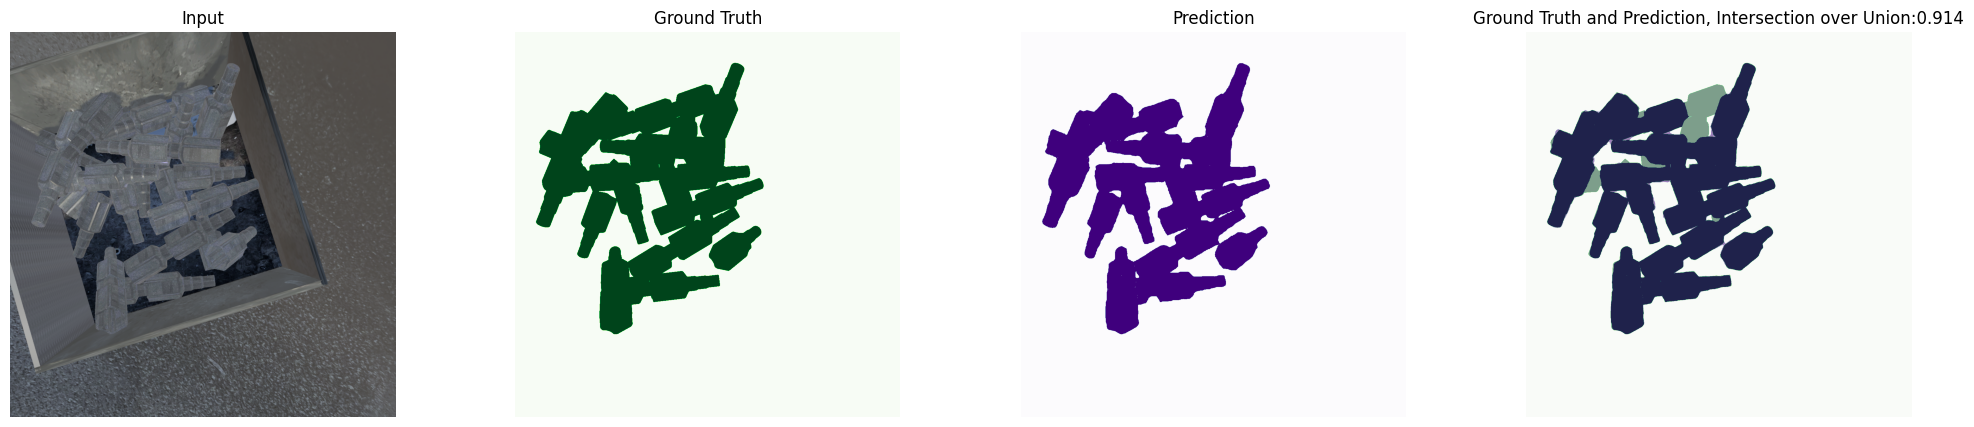

In [ ]:
Source_QC_folder = "/content/data_tiff/raw/images"
Target_QC_folder = "/content/data_tiff/raw/masks"

Channel_to_segment= "Grayscale"


Nuclear_channel= "None"


Object_diameter =  0

Flow_threshold = 0.3

mask_threshold=0

if Object_diameter is 0:
  Object_diameter = None
  print("The cell size will be estimated automatically for each image")


# Find the number of channel in the input image

random_choice = random.choice(os.listdir(Source_QC_folder))
x = io.imread(Source_QC_folder+"/"+random_choice)
n_channel = 1 if x.ndim == 2 else x.shape[-1]

if Channel_to_segment == "Grayscale":
  segment_channel = 0

  if not n_channel == 1:
      print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for QC !!")

if Channel_to_segment == "Blue":
  segment_channel = 3

if Channel_to_segment == "Green":
  segment_channel = 2

if Channel_to_segment == "Red":
  segment_channel = 1

if Nuclear_channel == "Blue":
  nuclear_channel = 3

if Nuclear_channel == "Green":
  nuclear_channel = 2

if Nuclear_channel == "Red":
  nuclear_channel = 1

if Nuclear_channel == "None":
  nuclear_channel = 0

if QC_model == "Cytoplasm":
  channels=[segment_channel,nuclear_channel]

if QC_model == "Cytoplasm2_Omnipose":
  channels=[segment_channel,nuclear_channel]

if QC_model == "Bacteria_Omnipose":
  channels=[segment_channel,nuclear_channel]

if QC_model == "Cytoplasm2":
  channels=[segment_channel,nuclear_channel]

if QC_model == "Nuclei":
  channels=[segment_channel,0]

if QC_model == "Own_model":
  channels=[segment_channel,nuclear_channel]

#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_folder+"/Quality Control") == False:
  os.makedirs(QC_model_folder+"/Quality Control")

if os.path.exists(QC_model_folder+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_folder+"/Quality Control/Prediction")
os.makedirs(QC_model_folder+"/Quality Control/Prediction")


# Here we need to make predictions

for name in os.listdir(Source_QC_folder):

  print("Performing prediction on: "+name)
  image = io.imread(Source_QC_folder+"/"+name)

  short_name = os.path.splitext(name)

  if QC_model == "Own_model" or QC_model == "LiveCell" or QC_model == "TissueNet":
    masks, flows, styles = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)
  else:
    masks, flows, styles, diams = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)

  print(masks)

  os.chdir(QC_model_folder+"/Quality Control/Prediction")
  imsave(str(short_name[0])+".tif", masks)

# Here we start testing the differences between GT and predicted masks

with open(QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])

# define the images

  for n in os.listdir(Source_QC_folder):

    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = io.imread(os.path.join(Source_QC_folder,n))
      test_prediction = io.imread(os.path.join(QC_model_folder+"/Quality Control/Prediction",n))
      test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics

      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)


      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])

from tabulate import tabulate

df = pd.read_csv (QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


from astropy.visualization import simple_norm

# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):


  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file), as_gray = True)

  target_image = io.imread(os.path.join(Target_QC_folder, file), as_gray = True)
  prediction = io.imread(QC_model_folder+"/Quality Control/Prediction/"+file, as_gray = True)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0

  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(QC_model_folder+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)


full_QC_model_path = QC_model_folder+'/'
qc_pdf_export()



In [ ]:
model.predict

# **6. Using the trained model**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.



## **6.1 Generate prediction(s) from unseen dataset (2D and 2D + t data)**
---

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the model's name and path to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contain the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output.

<font size = 4>**`Data_type`:** Please indicate if the images you want to predict are single images or stacks

<font size = 4>**`model_choice`:** Choose the model to use to make predictions. This model needs to be a Cellpose model. You can also use the pretrained models already available in cellpose:

- The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel.

- The cytoplasm2 model is an updated cytoplasm model trained with user-submitted images.

- The Nuclei model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is always set to an array of zeros.

- The 'LiveCell' model was trained on all training images from the [livecell dataset](https://sartorius-research.github.io/LIVECell/). These images only have a cytoplasm channel.

- The 'TissueNet' model was trained on all training images from the [tissuenet dataset](https://datasets.deepcell.org/). These images have a cytoplasm channel and a nuclear channel

- The bacteria Omnipose model is an Omnipose model dedicated to the segmentation of bacteria or other elongated cells.

- The cytoplasm2 Omnipose model is an Omnipose model trained using the same dataset as the cellpose cytoplasm2 model.

<font size = 4>**`Channel_to_segment`:** Choose the channel to segment. If using single-channel grayscale images, choose "Grayscale".

<font size = 4>**`Nuclear_channel`:** If you are using a model that segment the "cytoplasm", you can use a nuclear channel to aid the segmentation.

<font size = 4>**`Object_diameter`:** Indicate the diameter of the objects (cells or Nuclei) you want to segment (in pixel). If you input "0", this parameter will be estimated automatically for each of your images.

<font size = 4>**`Flow_threshold`:** This parameter controls the maximum allowed error of the flows for each mask. Increase this threshold if cellpose is not returning as many masks as you'd expect. Similarly, decrease this threshold if cellpose is returning too many ill-shaped masks. **Default value: 0.4**

<font size = 4>**`mask_threshold`:** The pixels greater than the mask_threshold are used to run dynamics and determine masks.  Decrease this threshold if cellpose is not returning as many masks as you'd expect. Similarly, increase this threshold if cellpose is returning too many masks, particularly from dim areas. **Default value: 0.0**

<font size = 4>**IMPORTANT:** One example result will be displayed first so that you can assess the quality of the prediction and change your settings accordingly. Once the most suitable settings have been chosen, press on the yellow button "process your images".








In [ ]:

#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Data_folder = "" #@param {type:"string"}
Result_folder = "" #@param {type:"string"}

#@markdown ###Are your data single images or stacks?

Data_type = "Single_Images" #@param ["Single_Images", "Stacks (2D + t)"]

#@markdown ###What model do you want to use?

model_choice = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2","LiveCell", "TissueNet", "Cytoplasm2_Omnipose", "Bacteria_Omnipose", "Nuclei", "Own_model"]

#@markdown ####If using your own model, please provide the path to the model (not the folder):

Prediction_model = "" #@param {type:"string"}

#@markdown ### What channel do you want to segment?

Channel_to_segment= "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you chose the model "cytoplasm" indicate if you also have a nuclear channel that can be used to aid the segmentation.

Nuclear_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ### Segmentation parameters:
Object_diameter =  0#@param {type:"number"}

Flow_threshold = 0.1 #@param {type:"slider", min:0.0, max:3, step:0.1}

mask_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

# Find the number of channel in the input image

random_choice = random.choice(os.listdir(Data_folder))
x = io.imread(Data_folder+"/"+random_choice)
n_channel = 1 if x.ndim == 2 else x.shape[-1]

if Channel_to_segment == "Grayscale":
  segment_channel = 0

  if Data_type == "Single_Images":
    if not n_channel == 1:
        print(bcolors.WARNING +"!! WARNING: your image has more than one channel, choose which channel you want to use for your predictions !!")

if Channel_to_segment == "Blue":
  segment_channel = 3

if Channel_to_segment == "Green":
  segment_channel = 2

if Channel_to_segment == "Red":
  segment_channel = 1

if Nuclear_channel == "Blue":
  nuclear_channel = 3

if Nuclear_channel == "Green":
  nuclear_channel = 2

if Nuclear_channel == "Red":
  nuclear_channel = 1

if Nuclear_channel == "None":
  nuclear_channel = 0

if model_choice == "Cytoplasm":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto")
  print("Cytoplasm model enabled")

if model_choice == "Cytoplasm2":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2")
  print("Cytoplasm2 model enabled")

if model_choice == "Cytoplasm2_Omnipose":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="cyto2_omni")
  print("Cytoplasm2_Omnipose model enabled")

if model_choice == "Nuclei":
  channels=[segment_channel,0]
  model = models.Cellpose(gpu=True, model_type="nuclei")
  print("Nuclei model enabled")

if model_choice == "LiveCell":
  channels=[segment_channel,0]
  model = models.CellposeModel(gpu=True, model_type="livecell")
  print("LiveCell model enabled")

if model_choice == "Bacteria_Omnipose":
  channels=[segment_channel,nuclear_channel]
  model = models.Cellpose(gpu=True, model_type="bact_omni")
  Object_diameter =  0
  print("Bacteria_omnipose model enabled")

if model_choice == "TissueNet":
  channels=[segment_channel,nuclear_channel]
  model = models.CellposeModel(gpu=True, model_type='tissuenet')
  print("TissueNet model enabled")

if model_choice == "Own_model":
  channels=[segment_channel,nuclear_channel]
  model = models.CellposeModel(gpu=True, pretrained_model=Prediction_model)

  print("Own model enabled")

if Object_diameter is 0:
  Object_diameter = None
  print("The cell size will be estimated automatically for each image")

if Data_type == "Single_Images" :

  print('--------------------------------------------------------------')
  @interact
  def preview_results(file = os.listdir(Data_folder)):
    source_image = io.imread(os.path.join(Data_folder, file))

    if model_choice == "Own_model" or model_choice == "LiveCell" or model_choice == "TissueNet":
      masks, flows, styles = model.eval(source_image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)

    else:
      masks, flows, styles, diams = model.eval(source_image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)

    flowi = flows[0]
    fig = plt.figure(figsize=(20,10))
    plot.show_segmentation(fig, source_image, masks, flowi, channels=channels)
    plt.tight_layout()
    plt.show()


  def batch_process():
      print("Your images are now beeing processed")

      for name in os.listdir(Data_folder):
        print("Performing prediction on: "+name)
        image = io.imread(Data_folder+"/"+name)
        short_name = os.path.splitext(name)

        if model_choice == "Own_model" or model_choice == "LiveCell" or model_choice == "TissueNet":
          masks, flows, styles = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)
        else:
          masks, flows, styles, diams = model.eval(image, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)

        os.chdir(Result_folder)
        imsave(str(short_name[0])+"_mask.tif", masks)

  im = interact_manual(batch_process)
  im.widget.children[0].description = 'Process your images'
  im.widget.children[0].style.button_color = 'yellow'
  display(im)

if Data_type == "Stacks (2D + t)" :
  print("Stacks (2D + t) are now beeing predicted")

  print('--------------------------------------------------------------')
  @interact
  def preview_results_stacks(file = os.listdir(Data_folder)):
    timelapse = imread(Data_folder+"/"+file)

    if model_choice == "Own_model" or model_choice == "LiveCell" or model_choice == "TissueNet":
      masks, flows, styles = model.eval(timelapse[0], diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)
    else:
      masks, flows, styles, diams = model.eval(timelapse[0], diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)

    flowi = flows[0]
    fig = plt.figure(figsize=(20,10))
    plot.show_segmentation(fig, timelapse[0], masks, flowi, channels=channels)
    plt.tight_layout()
    plt.show()

  def batch_process_stack():
      print("Your images are now beeing processed")
      for image in os.listdir(Data_folder):
        print("Performing prediction on: "+image)
        timelapse = imread(Data_folder+"/"+image)
        short_name = os.path.splitext(image)
        n_timepoint = timelapse.shape[0]
        prediction_stack = np.zeros((n_timepoint, timelapse.shape[1], timelapse.shape[2]))

        for t in range(n_timepoint):
          print("Frame number: "+str(t))
          img_t = timelapse[t]

          if model_choice == "Own_model" or model_choice == "LiveCell" or model_choice == "TissueNet":
            masks, flows, styles = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)
          else:
            masks, flows, styles, diams = model.eval(img_t, diameter=Object_diameter, flow_threshold=Flow_threshold,cellprob_threshold=mask_threshold, channels=channels)


          prediction_stack[t] = masks

        prediction_stack = img_as_float32(prediction_stack, force_copy=False)
        os.chdir(Result_folder)
        imsave(str(short_name[0])+".tif", prediction_stack, compression ='zlib')
        del prediction_stack

  im = interact_manual(batch_process_stack)
  im.widget.children[0].description = 'Process your images'
  im.widget.children[0].style.button_color = 'yellow'
  display(im)




In [ ]:
from cellpose import utils
from numba.experimental import jitclass
from numba import jit, float64


#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Data_folder = "" #@param {type:"string"}
Result_folder = "" #@param {type:"string"}

#@markdown ###What model do you want to use?
model_choice = "Cytoplasm" #@param ["Cytoplasm","Cytoplasm2", "Nuclei", "Own_model"]


#@markdown ####If using your own model, please provide the path to the model (not the folder):

Prediction_model = "" #@param {type:"string"}

#@markdown ### What channel do you want to segment?

Channel_to_segment= "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you chose the model "cytoplasm" indicate if you also have a nuclear channel that can be used to aid the segmentation.

Nuclear_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ###How do you want to generate the 3D labels?

#Choose_3D_mode = "2D predictions and stitching" #@param ["3D predictions", "2D predictions and stitching"]

Choose_3D_mode = "3D predictions" #@param ["3D predictions"]

#@markdown ### Segmentation parameters:
Object_diameter =  10#@param {type:"number"}
Anisotropy = 1 #@param {type:"number"}
Min_size = 200#@param {type:"number"}
mask_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

##@markdown ### Additional parameters for 2D predictions and stitching:

#Flow_threshold = 0.5 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
#Stitch_threshold= 0.1#@param {type:"slider", min:0, max:1.0, step:0.1}

#failsafes
if Choose_3D_mode == "3D predictions":
  do_3D = True
  Stitch_threshold= 0

  if Object_diameter == 0:
    Object_diameter= 40
    print("Object_diameter set to 40. If you want to use a different Object_diameter enable it in your segmentation parameters")

else:
  do_3D = False
  Anisotropy = 0

if Choose_3D_mode == "2D predictions and stitching" and Stitch_threshold== 0:
  Stitch_threshold= 0.5
  print("Stitch_threshold has now automatically be enabled with an IoU of 0.5. If you want to use a different threshold enable it in your segmentation parameters")


segment_channel = 0

if model_choice == "Own_model":
  channels=[segment_channel,nuclear_channel]
  model = models.CellposeModel(gpu=True, pretrained_model=Prediction_model, torch=True, diam_mean=30.0, net_avg=True, device=None, residual_on=True, style_on=True, concatenation=False)

  print("Own model enabled")